<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2">Imports</a></span></li><li><span><a href="#HMM---Hidden-Markov-Model" data-toc-modified-id="HMM---Hidden-Markov-Model-3">HMM - Hidden Markov Model</a></span></li><li><span><a href="#Fame-French-model" data-toc-modified-id="Fame-French-model-4">Fame-French model</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-5">Get the data</a></span></li><li><span><a href="#Selecting-a-stock-return" data-toc-modified-id="Selecting-a-stock-return-6">Selecting a stock-return</a></span></li><li><span><a href="#Gaussian-HMM" data-toc-modified-id="Gaussian-HMM-7">Gaussian HMM</a></span></li><li><span><a href="#Optimal-number-of-hidden-states---elbow-analysis" data-toc-modified-id="Optimal-number-of-hidden-states---elbow-analysis-8">Optimal number of hidden states - elbow analysis</a></span></li><li><span><a href="#Visualisation-of-the-states" data-toc-modified-id="Visualisation-of-the-states-9">Visualisation of the states</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-10">Comparison</a></span><ul class="toc-item"><li><span><a href="#Fama-French-Model-vs.-HMM" data-toc-modified-id="Fama-French-Model-vs.-HMM-10.1">Fama-French Model vs. HMM</a></span></li><li><span><a href="#Fama-French-Model-with-OLS" data-toc-modified-id="Fama-French-Model-with-OLS-10.2">Fama-French Model with OLS</a></span></li><li><span><a href="#Backtesting" data-toc-modified-id="Backtesting-10.3">Backtesting</a></span></li><li><span><a href="#Synthetic-Data-Generation-and-Hidden-Markov" data-toc-modified-id="Synthetic-Data-Generation-and-Hidden-Markov-10.4">Synthetic Data Generation and Hidden Markov</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-11">References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Synthetic data generation

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import yfinance as yf
import datetime
from matplotlib import rcParams
from hmmlearn import hmm
from matplotlib.dates import YearLocator, MonthLocator
from matplotlib import cm
import statsmodels.api as sm
#%matplotlib notebook
rcParams['figure.figsize'] = 6, 6
rcParams['font.size'] = 20

In [2]:
import warnings
warnings.filterwarnings('ignore')

# HMM - Hidden Markov Model
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 

- HMM gives us a probability distribution over sequential data, which is modeled by a Markov process with hidden states. HMM enables us to estimate probability transition from one state to another.

- To illustrate, let us consider the stock market, in which stocks go up, go down, or stay constant. Pick a random state—say, going up. The next state would be either going up, going down, or staying constant. In this context, the state is thought to be a hidden state because we do not know with certainty which state will prevail next in the market.
    
- HMM makes two assumptions:
    - All observations are solely dependent on the current state and are conditionally independent of other variables
    - The transition probabilities are homogenous and depend only on the current hidden state
    
</font>
</div> 

# Fame-French model
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
- The Fama-French model expands on the previous CAPM model. The model suggests  3 brand-new explanatory variables/factors to account for the changes in stock returns. 

    - [x] **market risk Rm − Rf** - is basically the return of a market portfolio minus the risk-free rate, which is a hypothetical rate proxied by government-issued T-bills or similar assets.
    - [x] **small minus big (SMB)** - is a proxy for size effect. Size effect is an important variable used to explain several phenomenon in corporate finance. It is represented by different variables like logarithm of total assets. Fama-French takes size effect into account by calculating between returns of small-cap companies and big-cap companies.
    - [x] **high minus low (HML)** - represents the spread in returns between companies with high book-to-market and companies with low book-to-market, comparing a company’s book value to its market value.    

- Empirical studies suggest that smaller SMB, higher HML, and smaller Rm−Rf boosts stock returns.

</font>
</div>

# Get the data
<hr style = "border:2px solid black" ></hr>

In [3]:
ff = pd.read_csv('./FF3.csv', skiprows=4)
ff = ff.rename(columns={'Unnamed: 0': 'Date'})
ff = ff.iloc[:-1]
ff.head()

,Date,Mkt-RF,SMB,HML,RF
0,19260701,0.10,-0.24,-0.28,0.009
1,19260702,0.45,-0.32,-0.08,0.009
2,19260706,0.17,0.27,-0.35,0.009
3,19260707,0.09,-0.59,0.03,0.009
4,19260708,0.21,-0.36,0.15,0.009


In [4]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24978 entries, 0 to 24977
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    24978 non-null  object 
 1   Mkt-RF  24978 non-null  float64
 2   SMB     24978 non-null  float64
 3   HML     24978 non-null  float64
 4   RF      24978 non-null  float64
dtypes: float64(4), object(1)
memory usage: 975.8+ KB


In [5]:
ff['Date'] = pd.to_datetime(ff['Date'])
ff.set_index('Date', inplace=True)
ff_trim = ff.loc['2000-01-01':]

In [6]:
ff_trim.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2000-01-03,-0.71,0.61,-1.40,0.021
2000-01-04,-4.06,0.01,2.06,0.021
2000-01-05,-0.09,0.18,0.19,0.021
2000-01-06,-0.73,-0.42,1.27,0.021
2000-01-07,3.21,-0.49,-1.42,0.021


# Selecting a stock-return
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- ETF is a special type of investment fund and exchange-traded product that tracks industry, commodities, and so on. 
- SPDR S&P 500 ETF (**SPY**) is a very well-known example tracking the S&P 500 Index. 

</font>
</div>

In [7]:
ticker = 'SPY'
start = datetime.datetime(2000, 1, 3)
end = datetime.datetime(2021, 4, 30)
SP_ETF = yf.download(ticker, start, end, interval='1d').Close

[*********************100%***********************]  1 of 1 completed


In [8]:
ff_merge = pd.merge(ff_trim, SP_ETF, how='inner', on='Date')

In [9]:
SP = pd.DataFrame()
SP['Close']= ff_merge['Close']

In [10]:
SP['return'] = (SP['Close'] / SP['Close'].shift(1))-1

In [11]:
ff_merge

,Mkt-RF,SMB,HML,RF,Close
Date,,,,,
2000-01-03,-0.71,0.61,-1.40,0.021,145.437500
2000-01-04,-4.06,0.01,2.06,0.021,139.750000
2000-01-05,-0.09,0.18,0.19,0.021,140.000000
2000-01-06,-0.73,-0.42,1.27,0.021,137.750000
2000-01-07,3.21,-0.49,-1.42,0.021,145.750000
...,...,...,...,...,...
2021-04-23,1.26,0.75,0.68,0.000,416.739990
2021-04-26,0.43,0.85,-0.48,0.000,417.609985
2021-04-27,-0.03,-0.17,0.85,0.000,417.519989


# Gaussian HMM
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- The data including return and volatility are used to define the the hidden states.
- It is assumed that there are three states in the economy: up, down, and constant. 
- With this in mind, we run the HMM with full covariance, indicating independent components and a number of iterations (n_iter) of 100. 
- The Gaussian HMM is used to predict the hidden state.
        
</font>
</div>

In [12]:
hmm_model = hmm.GaussianHMM(n_components=3,
                            covariance_type="full",
                            n_iter=100)

In [13]:
# Fitting the Gaussian HMM with return data
hmm_model.fit(np.array(SP['return'].dropna()).reshape(-1, 1))

# Given the return data, predicting the hidden states
hmm_predict = hmm_model.predict(np.array(SP['return'].dropna())
                                .reshape(-1, 1))

df_hmm = pd.DataFrame(hmm_predict)

In [14]:
ret_merged = pd.concat([df_hmm,SP['return'].dropna().reset_index()],
                       axis=1)
ret_merged.drop('Date',axis=1, inplace=True)
ret_merged.rename(columns={0:'states'}, inplace=True)
ret_merged.dropna().head()

,states,return
0,2,-0.039106
1,2,0.001789
2,2,-0.016071
3,2,0.058076
4,1,0.003431


In [15]:
ret_merged['states'].value_counts()

0    3014
1    2092
2     258
Name: states, dtype: int64

In [16]:
state_means = []
state_std = []

for i in range(3):
    state_means.append(ret_merged[ret_merged.states == i]['return']
                       .mean())
    state_std.append(ret_merged[ret_merged.states == i]['return']
                     .std())
print('State Means are: {}'.format(state_means))
print('State Standard Deviations are: {}'.format(state_std))

State Means are: [0.0009956956923795376, -0.0005000714110860053, -0.0018371952883552139]
State Standard Deviations are: [0.006006540155737145, 0.01372712345328387, 0.03598912028897814]


In [17]:
print(f'HMM means\n {hmm_model.means_}')
print(f'HMM covariances\n {hmm_model.covars_}')
print(f'HMM transition matrix\n {hmm_model.transmat_}')
print(f'HMM initial probability\n {hmm_model.startprob_}')

HMM means
 [[ 0.00100461]
 [-0.00036638]
 [-0.0023154 ]]
HMM covariances
 [[[3.84856800e-05]]

 [[1.82443149e-04]]

 [[1.26454102e-03]]]
HMM transition matrix
 [[9.80338159e-01 1.96606689e-02 1.17258840e-06]
 [2.69263672e-02 9.67137359e-01 5.93627345e-03]
 [2.05460614e-08 4.89263565e-02 9.51073623e-01]]
HMM initial probability
 [0.00000000e+000 1.14434993e-120 1.00000000e+000]


# Optimal number of hidden states - elbow analysis
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
-  We assume that the economy has three states, but this assumption rests on theory. 
- However we never know if this is the case, so which is the optimal number of hidden states? 
- **Elbow Analysis** will help us understand the optimal number of hidden states. After running Gaussian HMM, we obtain the likelihood result, and if there is no room for improvement—that is, the likelihood value becomes relatively stagnant, then this is the point at which we can stop the analysis. 
- Given the following result it turns out that three components is a good choice.

</font>
</div>

Text(0, 0.5, 'Log Likelihood')

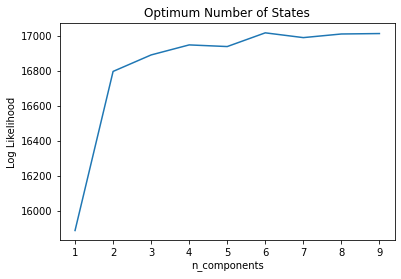

In [18]:
sp_ret = SP['return'].dropna().values.reshape(-1,1)
n_components = np.arange(1, 10)
clusters = [hmm.GaussianHMM(n_components=n, 
                            covariance_type="full").fit(sp_ret)
           for n in n_components]
plt.plot(n_components, [m.score(np.array(SP['return'].dropna())\
                                .reshape(-1,1)) for m in clusters])
plt.title('Optimum Number of States')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')

# Visualisation of the states
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 

- We are going to plot the the hidden state distributions.
- We can see how these are entirely different from each other, highlighting the importance of identifying the states.

</font>
</div>

In [19]:
hmm_model = hmm.GaussianHMM(n_components=3, 
                        covariance_type="full", 
                        random_state=123).fit(sp_ret)
hidden_states = hmm_model.predict(sp_ret)

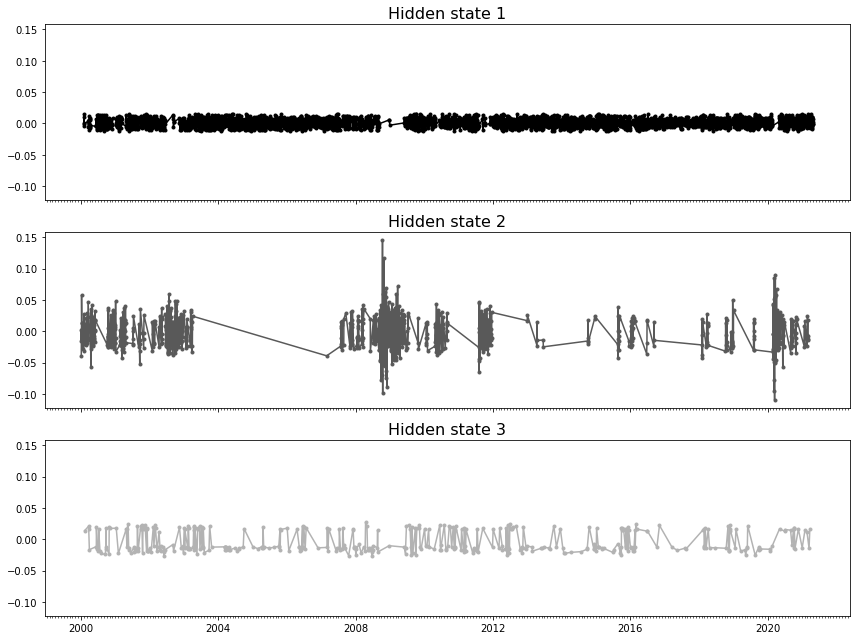

In [20]:
df_sp_ret = SP['return'].dropna()

hmm_model = hmm.GaussianHMM(n_components=3, 
                            covariance_type="full", 
                            random_state=123).fit(sp_ret)

hidden_states = hmm_model.predict(sp_ret)

fig, axs = plt.subplots(hmm_model.n_components, sharex=True,
                        sharey=True, figsize=(12, 9))
colors = cm.gray(np.linspace(0, 0.7, hmm_model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = hidden_states == i
    ax.plot_date(df_sp_ret.index.values[mask],
                 df_sp_ret.values[mask],
                 ".-", c=color)
    ax.set_title("Hidden state {}".format(i + 1), fontsize=16)
    ax.xaxis.set_minor_locator(MonthLocator())
plt.tight_layout()

In [21]:
ret_merged.groupby('states')['return'].mean()

states
0    0.000996
1   -0.000500
2   -0.001837
Name: return, dtype: float64

# Comparison
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>
 
- We can move forward and run the Fama-Frech three-factor model with and without Gaussian HMM. 
- The Sharpe ratio, which we’ll calculate after modeling, will tell us which is the better risk-adjusted return. 

</font>
</div>

## Fama-French Model vs. HMM

In [22]:
ff_merge['return'] = ff_merge['Close'].pct_change()
ff_merge.dropna(inplace=True)

In [23]:
split = int(len(ff_merge) * 0.9)
train_ff= ff_merge.iloc[:split].dropna()
test_ff = ff_merge.iloc[split:].dropna()

In [24]:
hmm_model = hmm.GaussianHMM(n_components=3,
                            covariance_type="full",
                            n_iter=100, init_params=" ")

In [25]:
predictions = []

for i in range(len(test_ff)):
    hmm_model.fit(train_ff)
    adjustment = np.dot(hmm_model.transmat_, hmm_model.means_)
    predictions.append(test_ff.iloc[i] + adjustment[0])
predictions = pd.DataFrame(predictions)

In [26]:
std_dev = predictions['return'].std()
sharpe = predictions['return'].mean() / std_dev
print('Sharpe ratio with HMM is {:.4f}'.format(sharpe))

Sharpe ratio with HMM is 0.0438


## Fama-French Model with OLS

<div class="alert alert-info">
<font color=black>

- The traditional way to run Fama-Frech three-factor model is to apply linear regression.

</font>
</div>

In [27]:
Y = train_ff['return']
X = train_ff[['Mkt-RF', 'SMB', 'HML']]

In [28]:
model = sm.OLS(Y, X)
ff_ols = model.fit()
print(ff_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          4.072e+04
Date:                Mon, 19 Sep 2022   Prob (F-statistic):                        0.00
Time:                        10:05:30   Log-Likelihood:                          22347.
No. Observations:                4827   AIC:                                 -4.469e+04
Df Residuals:                    4824   BIC:                                 -4.467e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
ff_pred = ff_ols.predict(test_ff[["Mkt-RF", "SMB", "HML"]])
ff_pred.head()

Date
2019-03-14   -0.000340
2019-03-15    0.005178
2019-03-18    0.004273
2019-03-19   -0.000194
2019-03-20   -0.003795
dtype: float64

In [30]:
std_dev = ff_pred.std()
sharpe = ff_pred.mean() / std_dev
print('Sharpe ratio with FF 3 factor model is {:.4f}'.format(sharpe))

Sharpe ratio with FF 3 factor model is 0.0589


## Backtesting


<div class="alert alert-info">
<font color=black>
 
- The following analysis tries to show what happens if the states of the index return need to be predicted based on the unseen data that can be used for backtesting for future analysis.

</font>
</div>


In [32]:
split = int(len(SP['return']) * 0.9)
train_ret_SP = SP['return'].iloc[split:].dropna()
test_ret_SP = SP['return'].iloc[:split].dropna()

In [33]:
hmm_model = hmm.GaussianHMM(n_components=3,
                            covariance_type="full",
                            n_iter=100)
hmm_model.fit(np.array(train_ret_SP).reshape(-1, 1))
hmm_predict_vol = hmm_model.predict(np.array(test_ret_SP)
                                    .reshape(-1, 1))
pd.DataFrame(hmm_predict_vol).value_counts()

0    4447
1     282
2      98
dtype: int64

## Synthetic Data Generation and Hidden Markov

<div class="alert alert-info">
<font color=black>

- HMM provides a helpful and strong way for further expanding our analysis to get more reliable and accurate results.

- Gaussina HHM can be used as a synthetic data generation process using Gaussian HMM. To do that, we should first define our initial parameters. These parameters are: initial probability (startprob), transition matrix (transmat), mean (means), and covariance (covars). 

- We can then run Gaussian HMM and apply a random sampling procedure to end up with a desired number of observations, which is 1,000 in our case.

</font>
</div>

In [34]:
startprob = hmm_model.startprob_
transmat = hmm_model.transmat_
means = hmm_model.means_ 
covars = hmm_model.covars_

In [35]:
syn_hmm = hmm.GaussianHMM(n_components=3, covariance_type="full")

In [36]:
syn_hmm.startprob_ = startprob
syn_hmm.transmat_ = transmat 
syn_hmm.means_ = means 
syn_hmm.covars_ = covars

In [37]:
syn_data, _ = syn_hmm.sample(n_samples=1000)

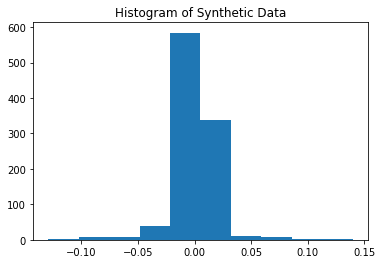

In [38]:
plt.hist(syn_data)
plt.title('Histogram of Synthetic Data')
plt.show()

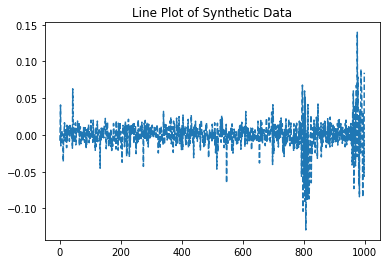

In [39]:
plt.plot(syn_data, "--")
plt.title('Line Plot of Synthetic Data')
plt.show()

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://github.com/abdullahkarasan/mlfrm/blob/main/codes/chp_10.ipynb
- Machine Learning for Financial Risk Management with Python Abdullah Karasan
- [FF3 dataset](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

</font>
</div>